# Timeseries via API

In this notebook we use the backend API to retrieve a time series and then plot it.

In [19]:
%matplotlib widget

import httpx
import matplotlib.pyplot as plt
import pandas as pd

coverage_identifier = "tas_absolute-rcp26-DJF"
point_coords = "POINT(11.5469 44.9524)"
date_range = "../.."
api_url = f"http://webapp:5001/api/v2/coverages/time-series/{coverage_identifier}"

### Time series without smoothing

In [20]:
raw_response = httpx.get(
    api_url,
    params={
        "coords": point_coords,
        "datetime": date_range,
        "include_coverage_data": True,
        "include_observation_data": True,
        "coverage_data_smoothing": "NO_SMOOTHING",
        "observation_data_smoothing": "NO_SMOOTHING",
        "include_coverage_uncertainty": False,
        "include_coverage_related_data": False,
    }
)
raw_response.raise_for_status()

raw_series = {}
for measurement in raw_response.json()["values"]:
    series_name = measurement["series"]
    measurement_series = raw_series.setdefault(series_name, list())
    measurement_series.append({"value": measurement["value"], "datetime": measurement["datetime"]})

raw_coverage_df = pd.DataFrame.from_dict(raw_series[coverage_identifier])
raw_station_df = pd.DataFrame.from_dict(raw_series["TDd"])

raw_coverage_df["datetime"] = pd.to_datetime(raw_coverage_df["datetime"])
raw_coverage_df.set_index("datetime", inplace=True)
raw_station_df["datetime"] = pd.to_datetime(raw_station_df["datetime"])
raw_station_df.set_index("datetime", inplace=True)

### Time series with smoothing

In [27]:
smoothed_response = httpx.get(
    api_url,
    params={
        "coords": point_coords,
        "datetime": date_range,
        "include_coverage_data": True,
        "include_observation_data": True,
        "coverage_data_smoothing": "MOVING_AVERAGE_11_YEARS",
        "observation_data_smoothing": "MOVING_AVERAGE_5_YEARS",
        "include_coverage_uncertainty": False,
        "include_coverage_related_data": False,
    }
)
smoothed_response.raise_for_status()

smoothed_series = {}
for measurement in smoothed_response.json()["values"]:
    series_name = measurement["series"]
    measurement_series = smoothed_series.setdefault(series_name, list())
    measurement_series.append({"value": measurement["value"], "datetime": measurement["datetime"]})

smoothed_coverage_df = pd.DataFrame.from_dict(smoothed_series[coverage_identifier])
smoothed_station_df = pd.DataFrame.from_dict(smoothed_series["TDd"])

smoothed_coverage_df["datetime"] = pd.to_datetime(smoothed_coverage_df["datetime"])
smoothed_coverage_df.set_index("datetime", inplace=True)
smoothed_station_df["datetime"] = pd.to_datetime(smoothed_station_df["datetime"])
smoothed_station_df.set_index("datetime", inplace=True)

### Plotting

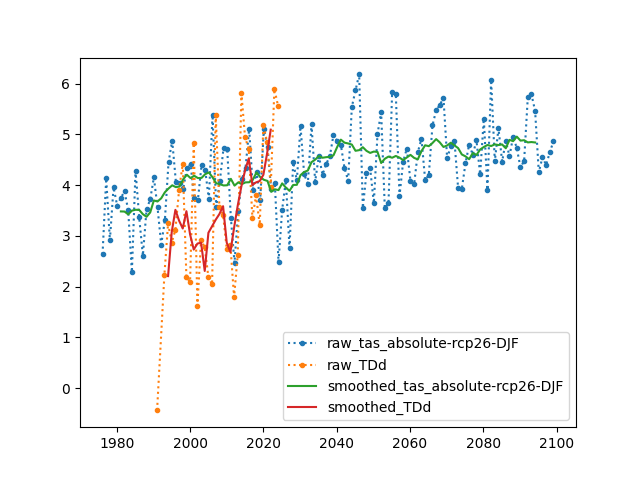

In [28]:
fig, ax = plt.subplots()
raw_tas_line, = ax.plot(raw_coverage_df, label=f"raw_{coverage_identifier}")
raw_station_line, = ax.plot(raw_station_df, label="raw_TDd")
raw_tas_line.set_linestyle(":")
raw_tas_line.set_marker(".")
raw_station_line.set_linestyle(":")
raw_station_line.set_marker(".")

smoothed_tas_line, = ax.plot(smoothed_coverage_df, label=f"smoothed_{coverage_identifier}")
smoothed_station_line, = ax.plot(smoothed_station_df, label="smoothed_TDd")
ax.legend()

In [23]:
ax.clear()